<a href="https://colab.research.google.com/github/sushkbura/Data-Science-in-Pandas/blob/main/Sush_MLE_MiniProject_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade scikit-learn scikeras

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


In [2]:
DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Download the dataset and load it into a pandas DataFrame
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country",
    "income"
]

adult_df = pd.read_csv(
    DATA_PATH,
    header=None,
    names=column_names,
    na_values=None,
    skipinitialspace=True
)

# Display the first few rows of the DataFrame
adult_df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Do some exploratory analysis. How many rows/columns are there? How are NULL
# values represented? What's the percentrage of positive cases in the dataset?

# Shape of the dataset
print("Shape of dataset (rows, columns):", adult_df.shape)

# Peek at unique values in a few categorical columns to see how NULLs may appear
for col in ["workclass", "occupation", "native-country"]:
    print(f"\nUnique values in '{col}' (showing up to 10):")
    print(adult_df[col].value_counts(dropna=False).head(10))

# In the Adult dataset, missing values are typically represented as " ?"
missing_like_question = (adult_df == " ?").sum()
print("\nCounts of ' ?' (string placeholder for missing values) per column:")
print(missing_like_question[missing_like_question > 0])

# Percentage of positive cases (income >50K)
positive_mask = adult_df["income"] == ">50K"
positive_percentage = positive_mask.mean() * 100
print(f"\nPercentage of positive cases (income >50K): {positive_percentage:.2f}%")


Shape of dataset (rows, columns): (32561, 15)

Unique values in 'workclass' (showing up to 10):
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

Unique values in 'occupation' (showing up to 10):
occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Name: count, dtype: int64

Unique values in 'native-country' (showing up to 10):
native-country
United-States    29170
Mexico             643
?                  583
Philippines        198
Germany            137
Canada             121
Puerto-Rico        114
El-Salvador        106
India              100
Cuba     

In [4]:
# Find all NULL values and drop them

# Replace " ?" with actual NaN to standardize missing value representation
adult_df_clean = adult_df.replace(" ?", np.nan)

# Count missing values per column before dropping
print("Missing values per column before dropping:")
print(adult_df_clean.isna().sum())

# Drop rows with any missing values
adult_df_clean = adult_df_clean.dropna()

print("\nShape after dropping rows with missing values:", adult_df_clean.shape)

Missing values per column before dropping:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

Shape after dropping rows with missing values: (32561, 15)


In [5]:
# Use Scikit-Learn's LabelEncoder to convert the income column with a data type
# string to a binary variable.

label_encoder = LabelEncoder()
adult_df_clean["income"] = label_encoder.fit_transform(adult_df_clean["income"])

# Show mapping
income_classes = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Income label mapping:", income_classes)

adult_df_clean[["income"]].head()


Income label mapping: {'<=50K': np.int64(0), '>50K': np.int64(1)}


,income
0,0
1,0
2,0
3,0
4,0


In [6]:
# Split dataset into training and test sets

# Separate features and target
X = adult_df_clean.drop("income", axis=1)
y = adult_df_clean["income"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Training target distribution:")
print(y_train.value_counts(normalize=True))


Training shape: (26048, 14)
Test shape: (6513, 14)
Training target distribution:
income
0    0.759175
1    0.240825
Name: proportion, dtype: float64


In [7]:
# Use Scikit-Learn's roc_auc_score to calculate the AUC score for a method that
# always predicts the majority class.

# Find the majority class in the training data
majority_class = y_train.value_counts().idxmax()
print("Majority class:", majority_class)

# Create constant predictions for the test set
y_pred_majority = np.full_like(y_test, fill_value=majority_class)

# Compute AUC using the constant predictions
baseline_auc = roc_auc_score(y_test, y_pred_majority)

print(f"Baseline AUC (always predicting majority class): {baseline_auc:.3f}")

Majority class: 0
Baseline AUC (always predicting majority class): 0.500


In [8]:
# Use Scikit-Learn's ColumnTransformer to apply One Hot Encoding to the
# categorical variables in workclass, education, marital-status, occupation,
# relationship, 'race', sex, and native-country. #Also, apply MinMaxScaler to
# the remaining continuous features.

categorical_features = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country"
]

numeric_features = [col for col in X_train.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", MinMaxScaler(), numeric_features),
    ]
)

# Fit the preprocessor on training data
preprocessor.fit(X_train)

# How many columns will the dataframe have after these columns transformations are applied?
X_train_transformed = preprocessor.transform(X_train)
print("Transformed training data shape:", X_train_transformed.shape)
print("Number of columns after transformation:", X_train_transformed.shape[1])


Transformed training data shape: (26048, 108)
Number of columns after transformation: 108


In [21]:
from keras.layers import Input # Import Input layer

def build_income_model(meta, **kwargs): # Accept meta dictionary
    n_features_in_ = meta["n_features_in_"] # Get n_features_in_ from meta
    model = Sequential()
    model.add(Input(shape=(n_features_in_,))) # Use Input layer
    model.add(Dense(32, activation='relu')) # No input_shape needed for subsequent Dense layers
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

In [22]:
# Create a Keras classifier

keras_clf = KerasClassifier(
    model=build_income_model,
    epochs=10,
    batch_size=256,
    verbose=1
)


In [23]:
# Create the scikit-learn pipeline

clf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", keras_clf)
])

clf_pipeline


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
# Fit the pipeline on the training data

history = clf_pipeline.fit(X_train, y_train)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.6042 - loss: 0.5621
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8732 - loss: 0.3689
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8890 - loss: 0.3486
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8939 - loss: 0.3411
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8997 - loss: 0.3331
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9002 - loss: 0.3305
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9005 - loss: 0.3276
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9036 - loss: 0.3242
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9098 - loss: 0.3151
Epoch 10/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9069 - loss: 0.3179


In [25]:
# Calculate the AUC score of your model on the test data.
# Does the model predict better than random?

# Get predicted probabilities for the positive class
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

model_auc = roc_auc_score(y_test, y_proba)
print(f"Model AUC on test data: {model_auc:.3f}")

if model_auc > 0.5:
    print("Yes, the model predicts better than random.")
else:
    print("No, the model does not predict better than random.")


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Model AUC on test data: 0.907
Yes, the model predicts better than random.


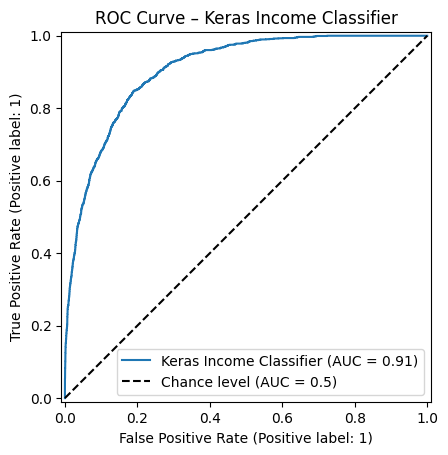

In [27]:
# Generate an ROC curve for your model.

RocCurveDisplay.from_predictions(
    y_test,
    y_proba,
    name="Keras Income Classifier", # Add a name for the curve
    plot_chance_level=True # Optionally plot the chance level
)
plt.title("ROC Curve – Keras Income Classifier")
plt.show()

After preprocessing, the dataset had 108 features, and the training/testing split was about 26k / 6.5k rows.

The training data was imbalanced (about 76% ≤50K and 24% >50K), which makes AUC a better metric than accuracy.

During training, the model’s AUC improved steadily each epoch and reached around 0.90, showing it learned meaningful patterns.

On the test data, the model achieved an AUC of 0.907, which is much better than random guessing (AUC = 0.5).

A random model would produce an ROC curve that looks like a diagonal line.

A perfect model would produce an ROC curve that goes straight up the left side and across the top, with an AUC of 1.0.

Since our ROC curve lies well above the diagonal and has a high AUC, the model shows strong ability to distinguish between people earning over $50K and those earning less.